# Accumulated local effects (ALE)

In [1]:
import numpy as np
import pandas as pd

# Simulate data
np.random.seed(0)
n_samples = 1000
temperature = np.random.uniform(0, 40, n_samples)  # Temperature in Celsius
time_of_day = np.random.uniform(0, 24, n_samples)  # Time of day in hours
day_of_week = np.random.randint(0, 7, n_samples)  # Day of the week (0=Sunday, 6=Saturday)

# Simulate electricity price with desired patterns
price = (0.2 * (temperature - 20)**2 +  # Quadratic effect of temperature
         5 * np.sin((time_of_day - 7) * np.pi / 6) * (time_of_day >= 7) * (time_of_day <= 10) +  # Peak between 7 AM and 10 AM
         5 * np.sin((time_of_day - 18) * np.pi / 4) * (time_of_day >= 18) * (time_of_day <= 22) +  # Peak between 6 PM and 10 PM
         -5 * np.sin((time_of_day - 10) * np.pi / 7) * (time_of_day >= 10) * (time_of_day <= 17) +  # Trough between 10 AM and 5 PM
         7 * np.sin((time_of_day) * np.pi / 24) +  # Sinusoidal effect throughout the day
         2 * (1 - np.cos(day_of_week * np.pi / 7)) +  # Higher prices on Sunday with smooth transition
         np.random.normal(0, 2, n_samples))  # Noise

# Convert to DataFrame for convenience
data = pd.DataFrame({
    'Temperature': temperature,
    'Hour': time_of_day,
    'Day': day_of_week,
    'Price': price
})

# Display the first few rows
data.head()


,Temperature,Hour,Day,Price
0,21.952540,14.229126,3,1.830310
1,28.607575,0.241529,3,16.398082
2,24.110535,11.419829,3,8.902574
3,21.795327,17.010489,5,9.614504
4,16.946192,1.055410,4,3.108261


In [2]:
from sklearn.ensemble import RandomForestRegressor

# Split data into features and target
X = data[['Temperature', 'Hour', 'Day']]
y = data['Price']

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=10, random_state=0)
model.fit(X, y)


RandomForestRegressor(n_estimators=10, random_state=0)

In [4]:
def calculate_ale(feature_name, feature_values, X, model, num_intervals=10):
    interval_edges = np.linspace(min(feature_values), max(feature_values), num_intervals + 1)
    ale_values = np.zeros(num_intervals)
    X_temp = X.copy()
    
    for i in range(num_intervals):
        lower = interval_edges[i]
        upper = interval_edges[i + 1]
        
        in_interval = (X[feature_name] >= lower) & (X[feature_name] < upper)
        if in_interval.sum() == 0:
            continue
        
        X_temp[feature_name] = lower
        preds_lower = model.predict(X_temp)
        
        X_temp[feature_name] = upper
        preds_upper = model.predict(X_temp)
        
        ale_values[i] = np.mean(preds_upper[in_interval] - preds_lower[in_interval])
    
    ale_accumulated = np.cumsum(ale_values)
    ale_accumulated -= np.mean(ale_accumulated)
    
    return interval_edges[:-1], ale_accumulated

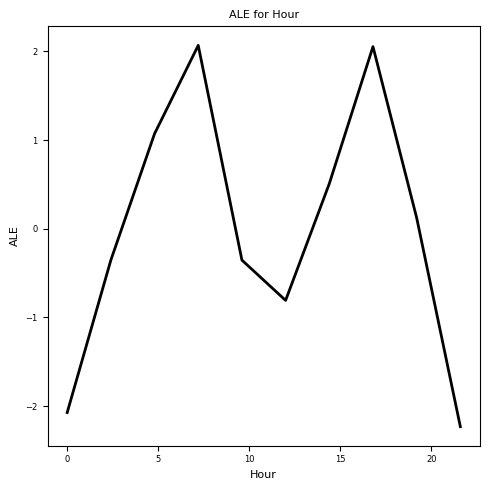

In [6]:
import matplotlib.pyplot as plt

# Calculate ALE for "Hour" feature
hour_values = np.linspace(0, 24, 100)
intervals_hour, ale_hour = calculate_ale('Hour', hour_values, X, model)

# Plot the ALE for "Hour" feature
plt.figure(figsize=(5, 5))
plt.plot(intervals_hour, ale_hour, color='k', linewidth=2)
plt.title('ALE for Hour', fontsize=8)
plt.xlabel('Hour', fontsize=8)
plt.ylabel('ALE', fontsize=8)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.show()

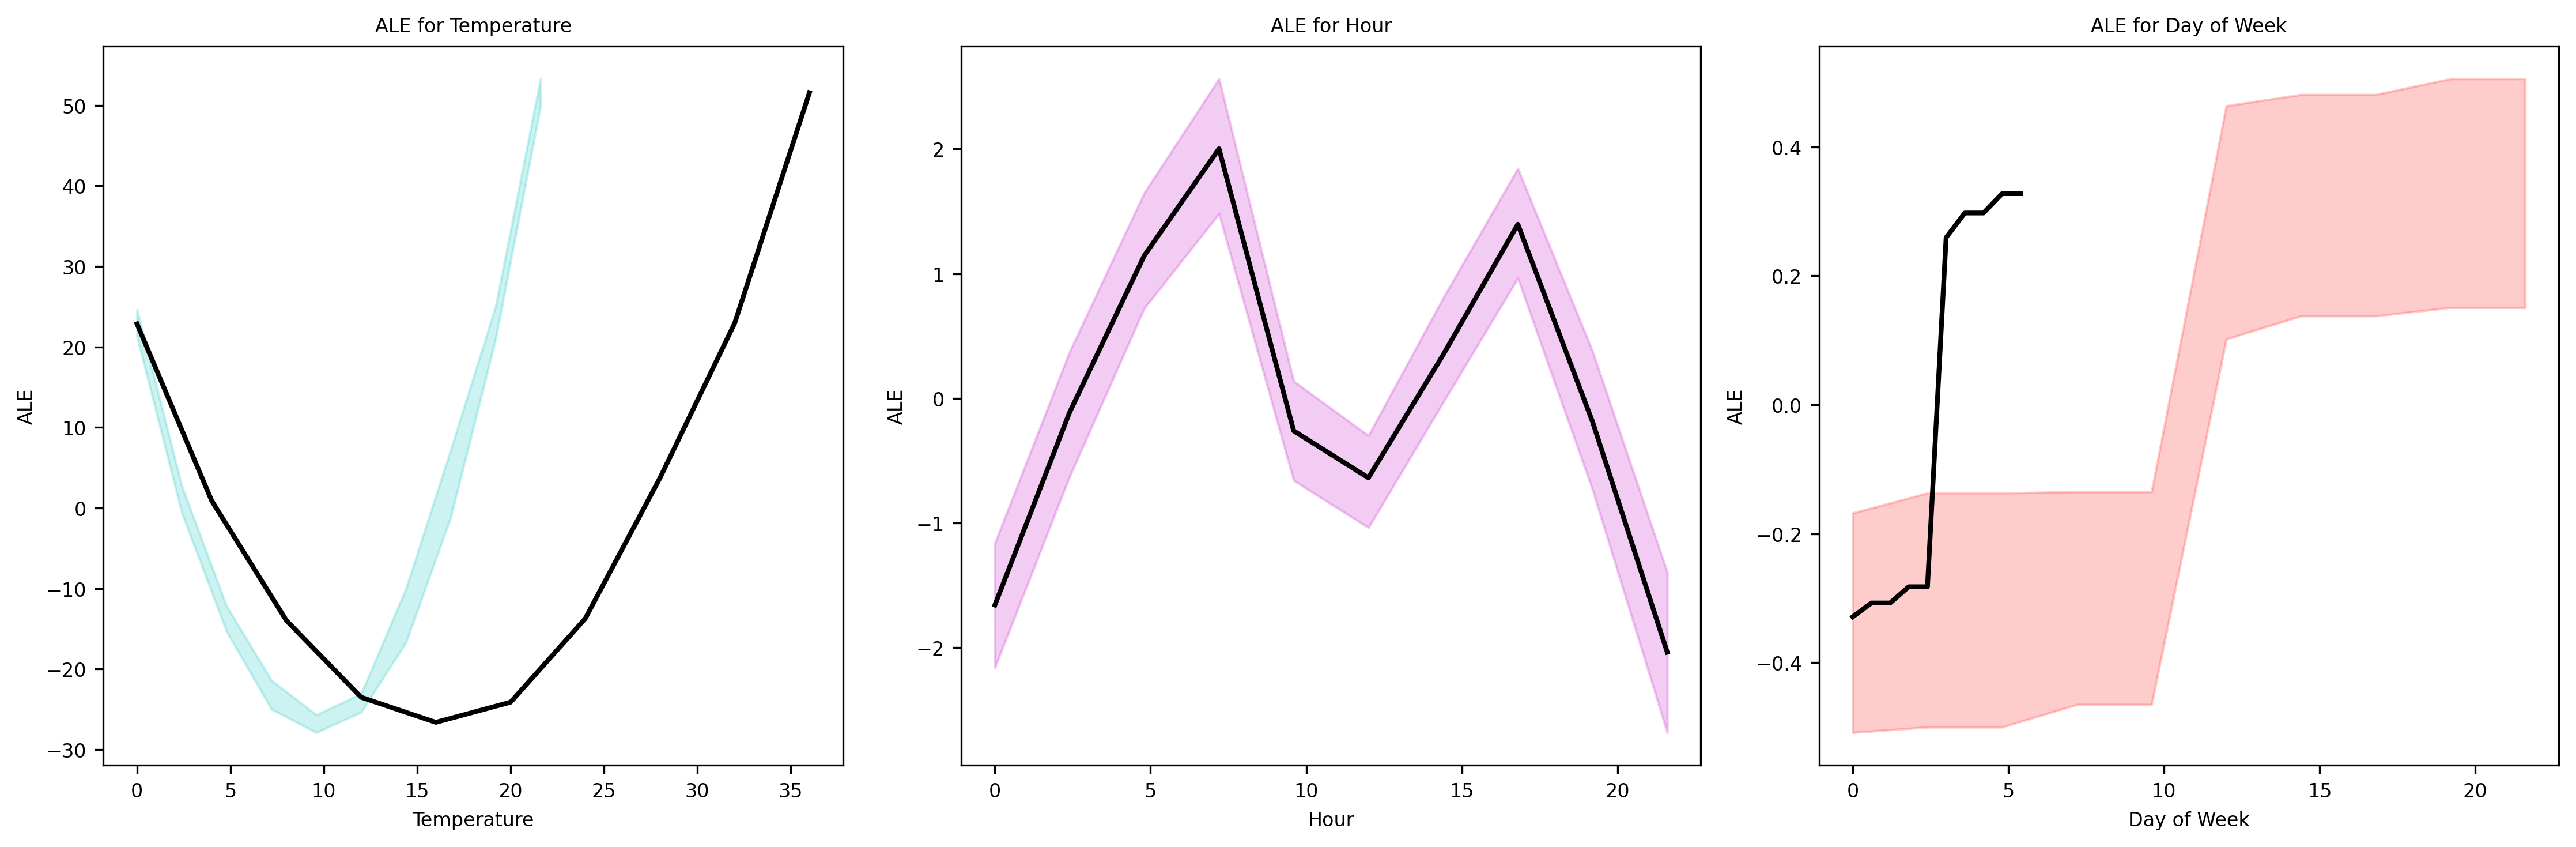

In [8]:
# Define the range of values for each feature
temperature_values = np.linspace(0, 40, 100)
hour_values = np.linspace(0, 24, 100)
day_values = np.arange(7)

# Calculate ALEs with bootstrapping
n_bootstraps = 100
ale_temperature_bootstraps = []
ale_hour_bootstraps = []
ale_day_bootstraps = []

for _ in range(n_bootstraps):
    # Bootstrap sample
    indices = np.random.choice(range(n_samples), size=n_samples, replace=True)
    X_bootstrap = X.iloc[indices]
    y_bootstrap = y.iloc[indices]
    
    # Train model on bootstrap sample
    model_bootstrap = RandomForestRegressor(n_estimators=10, random_state=0)
    model_bootstrap.fit(X_bootstrap, y_bootstrap)
    
    # Calculate ALEs for each feature
    intervals_temperature, ale_temperature = calculate_ale('Temperature', temperature_values, X, model_bootstrap)
    intervals_hour, ale_hour = calculate_ale('Hour', hour_values, X, model_bootstrap)
    intervals_day, ale_day = calculate_ale('Day', day_values, X, model_bootstrap)
    
    ale_temperature_bootstraps.append(ale_temperature)
    ale_hour_bootstraps.append(ale_hour)
    ale_day_bootstraps.append(ale_day)

# Convert results to numpy arrays for easier manipulation
ale_temperature_bootstraps = np.array(ale_temperature_bootstraps)
ale_hour_bootstraps = np.array(ale_hour_bootstraps)
ale_day_bootstraps = np.array(ale_day_bootstraps)

# Compute mean and confidence intervals
mean_ale_temperature = np.mean(ale_temperature_bootstraps, axis=0)
mean_ale_hour = np.mean(ale_hour_bootstraps, axis=0)
mean_ale_day = np.mean(ale_day_bootstraps, axis=0)
ci_temperature = np.percentile(ale_temperature_bootstraps, [2.5, 97.5], axis=0)
ci_hour = np.percentile(ale_hour_bootstraps, [2.5, 97.5], axis=0)
ci_day = np.percentile(ale_day_bootstraps, [2.5, 97.5], axis=0)

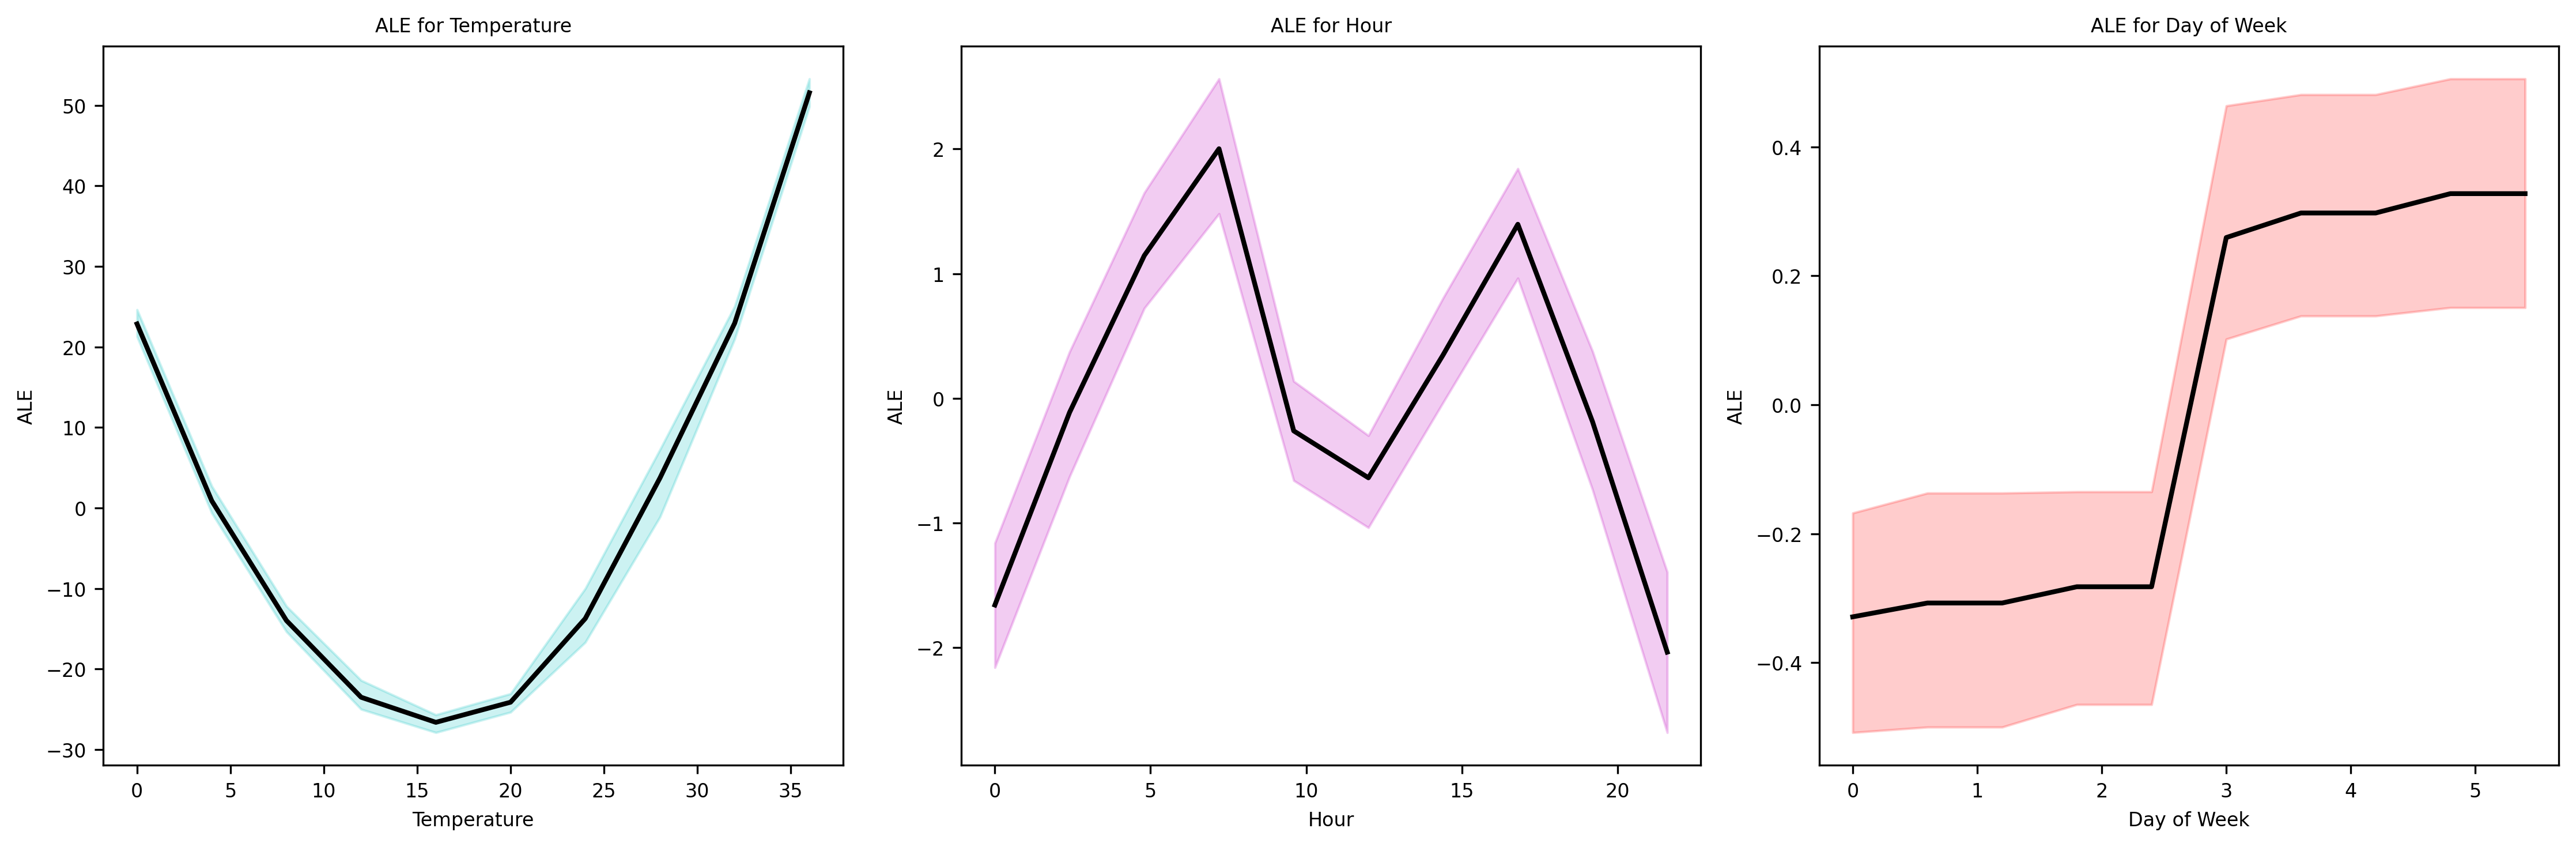

In [9]:
# Plot ALEs with confidence intervals
fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=300)

fontsize = 8  # Set the font size for all labels

# Temperature
ax[0].plot(intervals_temperature, mean_ale_temperature, label='ALE', color='k', linewidth=2)
ax[0].fill_between(intervals_temperature, ci_temperature[0], ci_temperature[1], color='c', alpha=0.2)
ax[0].set_title('ALE for Temperature', fontsize=fontsize)
ax[0].set_xlabel('Temperature', fontsize=fontsize)
ax[0].set_ylabel('ALE', fontsize=fontsize)
ax[0].tick_params(axis='both', which='major', labelsize=fontsize)

# Hour
ax[1].plot(intervals_hour, mean_ale_hour, label='ALE', color='k', linewidth=2)
ax[1].fill_between(intervals_hour, ci_hour[0], ci_hour[1], color='m', alpha=0.2)
ax[1].set_title('ALE for Hour', fontsize=fontsize)
ax[1].set_xlabel('Hour', fontsize=fontsize)
ax[1].set_ylabel('ALE', fontsize=fontsize)
ax[1].tick_params(axis='both', which='major', labelsize=fontsize)

# Day
ax[2].plot(intervals_day, mean_ale_day, label='ALE', color='k', linewidth=2)
ax[2].fill_between(intervals_day, ci_day[0], ci_day[1], color='r', alpha=0.2)
ax[2].set_title('ALE for Day of Week', fontsize=fontsize)
ax[2].set_xlabel('Day of Week', fontsize=fontsize)
ax[2].set_ylabel('ALE', fontsize=fontsize)
ax[2].tick_params(axis='both', which='major', labelsize=fontsize)

plt.tight_layout()
plt.show()
